# QIIME2 exploratory data analysis workshop

This workshop will guide you through a basic data processing pipeline using QIIME2 on a microbiome dataset. A large proportion will be exploratory data analysis, followed by some more specific statistical analysis and plotting of data.

By-and-large this workshop follows the steps in the [QIIME2 overview tutorial "moving pictures"](https://docs.qiime2.org/2019.7/tutorials/moving-pictures/). There are many more tutorials available on the [QIIME2 tutorial website](https://docs.qiime2.org/2019.7/tutorials/).

## Some basic QIIME2 concepts

For a detailed overview of QIIME2's concepts, [please consult the excellent documentation](https://docs.qiime2.org/2019.7/concepts/).

QIIME2 only handles most "raw" data (such as FASTQ files) on import and bundles data into `.qza` files - QIIME zipped *artifact*. In addition to the actual data, this includes meta-information, such as type of data and provenance.

*Visualisations* on the other hand are wrapped in `.qzv` files - QIIME zipped *visualisation*, with similar meta-information as *artifacts*. *Visualisation* files are usually the terminal output of a process or analysis.

QIIME2's extensive functionality is built with *plugins*. Each *plugin* might wrap specific programmes in other programming languages (such as C or Fortran) and generally fullfills one aspect of data processing or analysis. You can find a [full list of QIIME2 plugins on the website](https://docs.qiime2.org/2019.7/plugins/available/). Throughout this workshop you will also find links to corresponding tutorials.

The structure of QIIME2 commands is always similar, starting with `qiime` followed by the *plugin* name and several flags for options and file input or outputs. You can access the documentation by adding the `--help` flag, e.g.

In [ ]:
!qiime tools import --help

Note the exclaimation point (`!`) at the beginning of the command. This invokes the command as a `shell` operation rather than the default Python. Alternatively, you can use `%%bash` at the top of the cell to turn the cell into a `shell/bash` script.

You will frequently find `%%time` throughout this workshop, which will give you and idea how long it takes to execute code.

## Viewing *Visualisations* in Jupyter

*Visualisations* can be viewed with a QIIME view plugin, however, as we are working on a supercomputer, a so called 'headless' system without a graphic user interfact. Hence, throughout the analysis, we will do a little work-around using QIIME's `Visualization` Python package (note the American spelling).

We will therefore need to import the package.

In [50]:
from qiime2 import Visualization

*Visualisation* files can then be loaded through a Python command:

```python
Visualization.load('visualisation-file.qzv')
```

This will load the *Visualisation* in the output for the corresponding cell. Each *Visualisation* will also have an "open in new window" link to display the output in a new window/tab.

## The dataset and metadata

You will analyse an oral microbiome dataset. A total of 12 samples were collected by swabing the mouth between 8:00 and 18:00; one before brushing teeth, then hourly. The subject was a 21 year old male with good dental health on a vegan diet.

All metadata for this experiment has been [colated in a spreadsheet](https://docs.google.com/spreadsheets/d/1kdIW4xIxysbf0zQBzO4Y65B9sfaeTZywZ1CrMwWMd9k/edit?usp=sharing). Metadata files follow specific formatting rules (https://docs.qiime2.org/2019.7/tutorials/metadata/) and data included in the files can be used in some of the analyses by QIIME2.

To validate the metadata format, you can either use a QIIME2 plugin, or, more conveniently, use a Google sheets plugin called `Keemei` (Add-ons > Get Add-ons in the menu). Once validated, export the file as a tab-separated value (`.tsv`) file (under File > Download in the menu) and upload it to your working directory (drag and drop onto the files panel of Jupyter).

## Importing data with manifest

https://docs.qiime2.org/2019.7/tutorials/importing/

You will work a fraction (~5%) of the total dataset for this particular experiment (about a 1/400th of a full HiSeq run) to reduce computation time.

Let's copy the data to your working directory.

In [ ]:
!cp -rv /home/mbaron/qiime2_workshop/pe-reads/ .

Each of the samples is represented by one forward and one reverse read `.fastq` file - paired end reads. This means the data is already demultiplexed. The `manifest.txt` file in the `pe-reads` folder contains the sample ids and the file paths to each of the files.

To import the data as an *artifact*, `tools import` needs to be informed about the type of data (paired end sequences with quality information), the encoding of the quality scores (can be found in `metadata.yml`) and the filepaths through the manifest.

The import process will take a couple of seconds to a minute and create a `.qza` file.

In [23]:
%%time
!qiime tools import \
    --type 'SampleData[PairedEndSequencesWithQuality]' \
    --input-path pe-reads/manifest.txt \
    --output-path demux \
    --input-format PairedEndFastqManifestPhred33V2

Imported pe-reads/manifest.txt as PairedEndFastqManifestPhred33V2 to demux
CPU times: user 238 ms, sys: 81.5 ms, total: 319 ms
Wall time: 13.7 s


You can take a brief look at the file type and format using `tools peek`.

In [102]:
%%time
!qiime tools peek demux.qza

UUID:        c7d1e2f2-5eef-48c3-8df5-9c27e8928f95
Type:        SampleData[PairedEndSequencesWithQuality]
Data format: SingleLanePerSamplePairedEndFastqDirFmt
CPU times: user 0 ns, sys: 62.5 ms, total: 62.5 ms
Wall time: 1.45 s


### Visualising demultiplexed data

Once the data is imported, we can visualise the quality score information by creating a `.qzv` file. There are lots of different visualisation methods associated with different `.qza` files (see [available plugins](https://docs.qiime2.org/2019.7/plugins/available/)). `demux summarize` will provide you with an overview of sequences for each sample and an interactive chart displaying quality scores vs sequence length.

Do you see a marked drop in sequence quality?

In [24]:
%%time
!qiime demux summarize \
    --i-data demux.qza \
    --o-visualization demux.qzv

In [4]:
Visualization.load('demux.qzv')

<visualization: Visualization uuid: 4fc7715d-af4c-491e-8dd8-3af03260072f>

## Picking Amplicon Sequence Variants (ASV) with Deblur

The [Deblur](http://msystems.asm.org/content/2/2/e00191-16) algorithm uses error profiles to denoise the sequencing data and find true biological variants. We will quality filter our data by first by joining the paired-end reads. Any remaining low-quality read are removed a Q-score based filtering approach (as described in the lecture).

### Joining paired-end reads

https://docs.qiime2.org/2019.7/plugins/available/vsearch/join-pairs/

The expected size of the region amplified by the 515f and 806r primers is close to 250bp. As the data was generated by a HiSeq Rapid-Run with 250bp reads, the overlap between forward and reverse sequences is likely substaintial. `-p-minovlen` describes the minimum overlap between the reads, while `-p-maxdiffs` sets how many differences are tolerated. The default settings of the `vsearch` algorithm are rather lax, so the overlap was set to a minimum of 50bp (which would allow a total length of 450bp); no differences were tolerated.

In [25]:
%%time
!qiime vsearch join-pairs \
    --i-demultiplexed-seqs demux.qza \
    --output-dir joined \
    --p-minovlen 50 \
    --p-maxdiffs 0

Saved SampleData[JoinedSequencesWithQuality] to: joined/joined_sequences.qza
CPU times: user 553 ms, sys: 164 ms, total: 717 ms
Wall time: 29.6 s


In [26]:
%%time
!qiime demux summarize \
    --i-data joined/joined_sequences.qza \
    --o-visualization joined/joined_sequences.qzv

In [26]:
Visualization.load('joined/joined_sequences.qzv')

Saved Visualization to: joined/joined_sequences.qzv
CPU times: user 401 ms, sys: 138 ms, total: 540 ms
Wall time: 21 s


<visualization: Visualization uuid: 94828e46-12ac-4cee-a5bc-6ad3d593cc90>

### Quality filtering by Q-score

https://docs.qiime2.org/2019.7/plugins/available/quality-filter/q-score-joined/

In [27]:
%%time
!qiime quality-filter q-score-joined \
    --i-demux joined/joined_sequences.qza \
    --output-dir filtered

Saved SampleData[JoinedSequencesWithQuality] to: filtered/filtered_sequences.qza
Saved QualityFilterStats to: filtered/filter_stats.qza
CPU times: user 1.55 s, sys: 457 ms, total: 2 s
Wall time: 1min 22s


In [7]:
%%time
!qiime demux summarize \
    --i-data filtered/filtered_sequences.qza \
    --o-visualization filtered/filtered_sequences.qzv

Saved Visualization to: filtered/filtered_sequences.qzv
CPU times: user 675 ms, sys: 222 ms, total: 897 ms
Wall time: 32.9 s


In [8]:
Visualization.load('filtered/filtered_sequences.qzv')

<visualization: Visualization uuid: 4ebff90d-5cb5-41c7-8b58-939e23b0578a>

In [28]:
%%time
!qiime metadata tabulate \
  --m-input-file filtered/filter_stats.qza \
  --o-visualization filtered/filter_stats.qzv

In [6]:
Visualization.load('filtered/filter_stats.qzv')

<visualization: Visualization uuid: cfa414af-d44a-44d9-aac8-6ca30e5ecc50>

### Deblur

https://docs.qiime2.org/2019.7/plugins/available/deblur/denoise-16S/

With larger datasets, the actual Deblur step can be very time-consuming. With the current relatively small dataset, it should complete with a few minutes on the supercomputer.

This script can run in parallel on several CPU cores by using the `--p-jobs-to-start` flag. You will come across other plugins, which can also be parallelised, though the flags might be called differently, containg works like `threads` or `cores`. The majority of Cartesius compute nodes have 24 cores available.

The output is a feature table, statistics on the denoising and ASV-picking process as well as a file only containing key representative sequences (ASVs). The representative sequences, as a smaller file, allow faster construction of a phylogenetic tree or assignment of taxonomy.

In [29]:
%%time
!qiime deblur denoise-16S \
    --i-demultiplexed-seqs filtered/filtered_sequences.qza \
    --p-trim-length 251 \
    --output-dir deblur \
    --p-sample-stats \
    --p-jobs-to-start 24

Saved FeatureTable[Frequency] to: deblur/table.qza
Saved FeatureData[Sequence] to: deblur/representative_sequences.qza
Saved DeblurStats to: deblur/stats.qza
CPU times: user 9.61 s, sys: 2.77 s, total: 12.4 s
Wall time: 8min 7s


In [30]:
%%time
!qiime deblur visualize-stats \
    --i-deblur-stats deblur/stats.qza \
    --o-visualization deblur/stats.qzv

In [9]:
Visualization.load('deblur/stats.qzv')

<visualization: Visualization uuid: 292d0f74-deaf-49f2-bc92-6f7fce460317>

## Assigning taxonomy using the [Human Oral Microbiome Database (HOMD)](http://www.homd.org/index.php)

https://docs.qiime2.org/2019.7/tutorials/feature-classifier/

There are many references databases, some of the more popular general references, such as GreenGenes and Silva, can be found through the [QIIME data resources page](https://docs.qiime2.org/2019.7/data-resources/)

Using a more specialised a database has the advantage of more reliable and accurate taxonomy assignment. More specialised databases are usually smaller and allowing faster processing.

### Importing HOMD data

Two files are required to build a taxonomy classifier, the references sequences in `.fasta` format and text-file file liking the reference IDs with taxa. Both these files can be found on [HOMD ftp download pages for their 16S rRNA references](http://www.homd.org/ftp/16S_rRNA_refseq/HOMD_16S_rRNA_RefSeq/V15.2/). Let's make a new directory and download them directly using `wget`.

In [5]:
!mkdir homd
!wget -P homd "http://www.homd.org/ftp/16S_rRNA_refseq/HOMD_16S_rRNA_RefSeq/V15.2/HOMD_16S_rRNA_RefSeq_V15.2.fasta"
!wget -P homd "http://www.homd.org/ftp/16S_rRNA_refseq/HOMD_16S_rRNA_RefSeq/V15.2/HOMD_16S_rRNA_RefSeq_V15.2.qiime.taxonomy"

mkdir: cannot create directory ‘homd’: File exists
--2019-09-28 10:41:56--  http://www.homd.org/ftp/16S_rRNA_refseq/HOMD_16S_rRNA_RefSeq/V15.2/HOMD_16S_rRNA_RefSeq_V15.2.fasta
Resolving www.homd.org (www.homd.org)... 172.85.50.89
Connecting to www.homd.org (www.homd.org)|172.85.50.89|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1515134 (1.4M) [text/plain]
Saving to: ‘homd/HOMD_16S_rRNA_RefSeq_V15.2.fasta.1’

HOMD_16S_rRNA_RefSe 100%[===================>]   1.44M  1.15MB/s    in 1.3s    

2019-09-28 10:41:57 (1.15 MB/s) - ‘homd/HOMD_16S_rRNA_RefSeq_V15.2.fasta.1’ saved [1515134/1515134]

--2019-09-28 10:41:57--  http://www.homd.org/ftp/16S_rRNA_refseq/HOMD_16S_rRNA_RefSeq/V15.2/HOMD_16S_rRNA_RefSeq_V15.2.qiime.taxonomy
Resolving www.homd.org (www.homd.org)... 172.85.50.89
Connecting to www.homd.org (www.homd.org)|172.85.50.89|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 128955 (126K) [text/plain]
Saving to: ‘homd/HOMD_16S_rRNA_RefS

For importing, `tools import` does the job. Note that we specifying different `--type` for each of the imports.

In [6]:
%%time
# importing HOMD data
!qiime tools import \
    --type 'FeatureData[Sequence]' \
    --input-path homd/HOMD_16S_rRNA_RefSeq_V15.2.fasta \
    --output-path homd/HOMD_16S_rRNA_RefSeq_V15.2

Imported homd/HOMD_16S_rRNA_RefSeq_V15.2.fasta as DNASequencesDirectoryFormat to homd/HOMD_16S_rRNA_RefSeq_V15.2
CPU times: user 0 ns, sys: 15.6 ms, total: 15.6 ms
Wall time: 14.9 s


In [7]:
%%time
!qiime tools import \
    --type 'FeatureData[Taxonomy]' \
    --input-format HeaderlessTSVTaxonomyFormat \
    --input-path homd/HOMD_16S_rRNA_RefSeq_V15.2.qiime.taxonomy \
    --output-path homd/HOMD_16S_rRNA_RefSeq_V15.2.qiime.taxonomy

Imported homd/HOMD_16S_rRNA_RefSeq_V15.2.qiime.taxonomy as HeaderlessTSVTaxonomyFormat to homd/HOMD_16S_rRNA_RefSeq_V15.2.qiime.taxonomy
CPU times: user 0 ns, sys: 15.6 ms, total: 15.6 ms
Wall time: 3.66 s


### Trimming references with primer sequences

https://docs.qiime2.org/2019.7/plugins/available/feature-classifier/extract-reads/

Trimming the reference database to the region of interest (in our case between 515f and 806r), also ensure more reliable assignment of taxonomy. To do so, the plugin requires the annealing regions of both primer sequences (note the degenerate bases e.g `M`) and minimum and maximum expected sequence lengths. As the region should be around 250 bp, a minimum length of 100 bp and a maximum length of 400 bp should reduce spurious sequences.

In [8]:
%%time
## extracting reads according to primers
!qiime feature-classifier extract-reads \
    --i-sequences homd/HOMD_16S_rRNA_RefSeq_V15.2.qza \
    --p-f-primer GTGCCAGCMGCCGCGGTAA \
    --p-r-primer GGACTACHVGGGTWTCTAAT \
    --p-min-length 100 \
    --p-max-length 400 \
    --o-reads homd/HOMD_16S_rRNA_RefSeq_V15.2_trimmed.qza

Saved FeatureData[Sequence] to: homd/HOMD_16S_rRNA_RefSeq_V15.2_trimmed.qza
CPU times: user 0 ns, sys: 15.6 ms, total: 15.6 ms
Wall time: 4.89 s


### Assigning taxonomy

https://docs.qiime2.org/2019.7/plugins/available/feature-classifier/classify-consensus-vsearch/

VSEARCH is used to align our query sequences (remember the representative sequences generated by Deblur?) with the reference and assign taxonomy.

In [11]:
%%time
!qiime feature-classifier classify-consensus-vsearch \
    --i-query deblur/representative_sequences.qza \
    --i-reference-reads homd/HOMD_16S_rRNA_RefSeq_V15.2_trimmed.qza \
    --i-reference-taxonomy homd/HOMD_16S_rRNA_RefSeq_V15.2.qiime.taxonomy.qza \
    --output-dir taxonomy \
    --p-threads 24

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command: vsearch --usearch_global /tmp/qiime2-archive-dj6whxrs/4e6b508b-e5a8-465f-900e-76c4ac0c0435/data/dna-sequences.fasta --id 0.8 --query_cov 0.8 --strand both --maxaccepts 10 --maxrejects 0 --output_no_hits --db /tmp/qiime2-archive-hu10z7by/c4840b33-4fd1-44de-b866-a65ae794cced/data/dna-sequences.fasta --threads 4 --blast6out /tmp/tmptephxpfj

vsearch v2.7.0_linux_x86_64, 23.9GB RAM, 4 cores
https://github.com/torognes/vsearch

Reading file /tmp/qiime2-archive-hu10z7by/c4840b33-4fd1-44de-b866-a65ae794cced/data/dna-sequences.fasta 100%  
256605 nt in 1015 seqs, min 252, max 255, avg 253
Masking 100%  
Counting k-mers 100%  
Creating k-mer index 100%  
Searching 100%     
Matching query sequences: 338 of 346 (97.69%)
Saved FeatureData[Taxonomy] to: taxonomy/classif

### Taxa bar-plot

https://docs.qiime2.org/2019.7/plugins/available/taxa/barplot/

A convenient way to visualise taxonomy is through stacked bar-charts. Do you see any trends in any taxa throughout the day? We'll get back to the taxonomy data later.

In [12]:
%%time
!qiime taxa barplot \
    --i-table deblur/table.qza \
    --i-taxonomy taxonomy/classification.qza \
    --m-metadata-file oral_microbiome.tsv \
    --o-visualization taxonomy/bar-plot.qzv

Saved Visualization to: taxonomy/bar-plot.qzv
CPU times: user 0 ns, sys: 15.6 ms, total: 15.6 ms
Wall time: 5.49 s


In [5]:
Visualization.load('taxonomy/bar-plot.qzv')

<visualization: Visualization uuid: efa946bb-b2b0-4cd0-abad-42a59fa3aff8>

## Generating a phylogenetic tree

https://docs.qiime2.org/2019.7/plugins/available/phylogeny/align-to-tree-mafft-fasttree/

Several phylogeny-based diversity metrics require a phylogenetic tree. This pipeline method will align all the sequences, denoise the data and construct both a rooted and unrooted phylogenetic tree. Again, using only the representative sequences speeds up this process.

In [14]:
%%time
!qiime phylogeny align-to-tree-mafft-fasttree \
    --i-sequences deblur/representative_sequences.qza \
    --p-n-threads 24 \
    --output-dir phylogeny

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command: mafft --preservecase --inputorder --thread 4 /tmp/qiime2-archive-5zwi1t4y/4e6b508b-e5a8-465f-900e-76c4ac0c0435/data/dna-sequences.fasta


inputfile = orig
346 x 251 - 251 d
nthread = 4
stacksize: 8192 kb
generating a scoring matrix for nucleotide (dist=200) ... done
Gap Penalty = -1.53, +0.00, +0.00



Making a distance matrix ..
  301 / 346 (thread    2)
done.

Constructing a UPGMA tree (efffree=0) ... 
  340 / 346
done.

Progressive alignment 1/2... 
STEP   172 / 345 (thread    3)ff
Reallocating..done. *alloclen = 1503
STEP   345 / 345 (thread    3)d
done.

Making a distance matrix from msa.. 
  300 / 346 (thread    0)
done.

Constructing a UPGMA tree (efffree=1) ... 
  340 / 346
done.

Progressive alignment 2/2... 
STEP   217 / 345 (thread    3)f
Realloca

### Visualise phylogentic tree

QIIME2 doesn't yet have plugins to visualise phylogenetic trees. If you like to see the tree, download your `phylogeny/tree.qza` file (right-click on the file in the file panel and download) and upload it to [Interactive Tree Of Life](https://itol.embl.de/upload.cgi), a tool by maintained by the EMBL.

For full annotation of the leafs, also download `taxonomy/classification.qza` and drag and drop the file onto the tree. The [iTOL help pages list several other QIIME2 artifacts which can be applied to the tree](https://itol.embl.de/help.cgi#qiime).

## Alpha and beta diversity

https://docs.qiime2.org/2019.7/plugins/available/diversity/core-metrics-phylogenetic/

The core metrics pipeline is a handy tool to generate a whole array of alpha and beta diversity metrics. [This excellent post on the QIIME2 forum](https://forum.qiime2.org/t/alpha-and-beta-diversity-explanations-and-commands/2282) gives a brief overview with papers for each available metric. As mentioned in the lecture, there are many metrics, many of which originating form the much older field of echology. Given that we work with sequencing data you might want to focus at first on phylogenetic metrics, such as [Faith's Phylogenetic Distance](https://en.wikipedia.org/wiki/Phylogenetic_diversity) for alpha diversity and UniFrac for beta diversity.

The pipeline required a rooted phylogenetic tree, the feature table, the meta-data file, as well as a sampling-depth parameter. Each sample will be randomly subsampled (rarefied) to the depth of `--p-sampling-depth` to ensure even representation. Any sample smaller than the sampling depth will be excluded. Consequently, this is a tradeoff between depth of the analysis and number of samples retained.

You need to check your visualisation of the Deblur-statistics for sampling depth. Sort the data by the `read-hit-reference`. Is there a large difference between the most and least numerous sample?

In [19]:
%%time
!qiime diversity core-metrics-phylogenetic \
    --i-phylogeny phylogeny/rooted_tree.qza \
    --i-table deblur/table.qza \
    --p-sampling-depth 18435 \
    --m-metadata-file oral_microbiome.tsv \
    --output-dir alpha_beta \
    --p-n-jobs 24

/home/Mike/anaconda3/envs/qiime2-2019.7/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:1575: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/home/Mike/anaconda3/envs/qiime2-2019.7/lib/python3.6/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.003167010356636358 and the largest is 1.9536882302705858.
  RuntimeWarning
/home/Mike/anaconda3/envs/qiime2-2019.7/lib/python3.6/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude w

[Ordination](https://en.wikipedia.org/wiki/Ordination_(statistics)) is a popular tool to explore microbial communities. We can use the [Emperor tool](https://biocore.github.io/emperor/description_index.html) to inspect [principal coordinate analysis (PCoA)](https://moodle.ucl.ac.uk/mod/page/view.php?id=988175) plots. Due to a bug in the QIIME2 implementations data labels can not be set, however when you click on a sample point, its label is revealed in the bottom left corner of the plot.

In [23]:
Visualization.load('alpha_beta/jaccard_emperor.qzv')

<visualization: Visualization uuid: 4c8bfaba-1c65-446c-a9df-2e94ea00ede0>

### Alpha diversity correlation

https://docs.qiime2.org/2019.7/plugins/available/diversity/alpha-correlation/

Given that this dataset is a time-series, it makes sense to look for correlation over time. The alpha-correlation method will determine whether any numeric data provided in the metadata file are correlated with alpha diversity. By default it will apply a [Spearman's rank correlation test](https://statistics.laerd.com/spss-tutorials/spearmans-rank-order-correlation-using-spss-statistics.php), generate a correlation coefficient (-1 to 1) and a p-value. Is the correlation significant?

In [30]:
%%time
!qiime diversity alpha-correlation \
  --i-alpha-diversity alpha_beta/faith_pd_vector.qza \
  --m-metadata-file oral_microbiome.tsv \
  --o-visualization alpha_beta/faith_pd_correlation

Saved Visualization to: alpha_beta/faith_pd_correlation.qzv
CPU times: user 0 ns, sys: 15.6 ms, total: 15.6 ms
Wall time: 5.13 s


In [51]:
Visualization.load('alpha_beta/faith_pd_correlation.qzv')

<visualization: Visualization uuid: 7334f51c-2fa6-4e4c-ba68-433d7479a9df>

### Alpha rarefaction curves

https://docs.qiime2.org/2019.7/plugins/available/diversity/alpha-rarefaction/

Rarefaction curves are generated by randomly sub-sampling data from each sample at increasing depth (up to `-p-max-depth`). Each sub-sampling is repeated several times (default: 10) and alpha diversity metric are calculated. As the sampling depth increases, so should the diversity indices. If the curves plateau or level out, increasing sequencing depth would unlikely increase the number of features deteced.

Hence, alpha rarefaction curves are a tool to determine whether most of the diversity had been captured through sequencing.

In [39]:
%%time
!qiime diversity alpha-rarefaction \
    --i-table deblur/table.qza \
    --i-phylogeny phylogeny/rooted_tree.qza \
    --p-max-depth 18435 \
    --m-metadata-file oral_microbiome.tsv \
    --p-steps 20 \
    --o-visualization alpha_beta/rarefaction

Saved Visualization to: alpha_beta/rarefaction.qzv
CPU times: user 0 ns, sys: 46.9 ms, total: 46.9 ms
Wall time: 15.5 s


In [55]:
Visualization.load('alpha_beta/rarefaction.qzv')

<visualization: Visualization uuid: bd3257d7-1597-4f28-ba23-9b584382043b>

## Further correlation analysis of taxonomic data with Python

The significant decrease in alpha diversity throughout the day suggests that taxa change significantly throughout the day. Usually a drop in diversity is associated with some taxa increasing relative abundance, ie. outcompeting others.

What better way to test this than with a few quick correlation tests in Python through the [Pandas](https://pandas.pydata.org/) packages.

First we'll export the bar-plot data and import with Pandas.

In [4]:
%%time
!qiime tools export \
    --input-path taxonomy/bar-plot.qzv \
    --output-path taxonomy/bar-plot

Exported taxonomy/bar-plot.qzv as Visualization to directory taxonomy/bar-plot
CPU times: user 0 ns, sys: 15.6 ms, total: 15.6 ms
Wall time: 1.61 s


In [45]:
# loading pandas package
import pandas as pd
# jupyter magic to display plots inline
%matplotlib inline

In [55]:
# loading data into a Pandas dataframe
# 'time' is set as the row-index column, times are parsed by Python
df = pd.read_csv('taxonomy/bar-plot/level-6.csv',index_col='time',parse_dates=True)

In [56]:
# sorting data by index (inplace to overwrite dataframe)
df.sort_index(inplace=True)
# rows are now sorted by time / sample
df.index

DatetimeIndex(['2019-09-30 08:00:00', '2019-09-30 08:02:00',
               '2019-09-30 09:00:00', '2019-09-30 10:00:00',
               '2019-09-30 11:00:00', '2019-09-30 12:00:00',
               '2019-09-30 13:00:00', '2019-09-30 14:00:00',
               '2019-09-30 15:00:00', '2019-09-30 16:00:00',
               '2019-09-30 17:00:00', '2019-09-30 18:00:00'],
              dtype='datetime64[ns]', name='time', freq=None)

In [57]:
# provides overview of dataframe
print(df.info())
# shows first couple of rows of dataframe
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12 entries, 2019-09-30 08:00:00 to 2019-09-30 18:00:00
Data columns (total 67 columns):
index                                                                                                                                                                              12 non-null object
Unassigned;__;__;__;__;__                                                                                                                                                          12 non-null float64
k__Bacteria;p__Absconditabacteria_(SR1);c__Absconditabacteria_(SR1)_[C-1];o__Absconditabacteria_(SR1)_[O-1];f__Absconditabacteria_(SR1)_[F-1];g__Absconditabacteria_(SR1)_[G-1]    12 non-null float64
k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;__;__                                                                                                           12 non-null float64
k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetal

,index,Unassigned;__;__;__;__;__,k__Bacteria;p__Absconditabacteria_(SR1);c__Absconditabacteria_(SR1)_[C-1];o__Absconditabacteria_(SR1)_[O-1];f__Absconditabacteria_(SR1)_[F-1];g__Absconditabacteria_(SR1)_[G-1],k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;__;__,k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;__,k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces,k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Micrococcaceae;__,k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;__,k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium,k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Corynebacteriaceae;g__Corynebacterium,...,k__Bacteria;p__Spirochaetes;c__Spirochaetia;o__Spirochaetales;f__Spirochaetaceae;g__Treponema,barcode-sequence,time-past-brushing-hours,liquid-consumed,liquid-type,volume-ml,food-consumed,food,refined-sugars-g,teeth-brushing
time,,,,,,,,,,,,,,,,,,,,,
2019-09-30 08:00:00,s01,0.0,36.0,24.0,0.0,447.0,708.0,0.0,0.0,880.0,...,0.0,GTGAATGTTCGA,0.000000,Y,Water,250.0,N,N,0.0,N
2019-09-30 08:02:00,s02,12.0,67.0,45.0,5.0,526.0,801.0,131.0,0.0,1791.0,...,13.0,TATGTTGACGGC,0.033333,N,NaN,0.0,N,N,0.0,Y
2019-09-30 09:00:00,s03,12.0,10.0,24.0,3.0,1067.0,2070.0,0.0,0.0,3219.0,...,22.0,AGTGTTTCGGAC,1.000000,N,NaN,0.0,N,N,0.0,N
2019-09-30 10:00:00,s04,62.0,0.0,3.0,11.0,667.0,2282.0,0.0,0.0,1302.0,...,0.0,ATTTCCGCTAAT,2.000000,Y,Water,250.0,Y,"5 pancakes, 1 banana, 1tbsp syrup",24.0,N
2019-09-30 11:00:00,s05,24.0,6.0,260.0,5.0,604.0,1955.0,0.0,0.0,2340.0,...,0.0,CAAACCTATGGC,3.000000,Y,Tea,250.0,N,N,0.0,N


In [58]:
# data is in absolute counts
# to get relative abundances, the data needs to be normalised
# create a selector for the columns (in this case for the first and last taxonomy column in the dataframe)
start, end = df.columns.get_indexer(['Unassigned;__;__;__;__;__','k__Bacteria;p__Spirochaetes;c__Spirochaetia;o__Spirochaetales;f__Spirochaetaceae;g__Treponema'])
taxa_columns = df.columns[start:end]
df['all'] = df.loc[:,taxa_columns].sum(axis=1)
# divide each taxonomy count by the total value, mulitply by 100
df.loc[:,taxa_columns] = df.loc[:,taxa_columns].div(df['all'],axis=0).mul(100,axis=0)

In [59]:
df.head()

,index,Unassigned;__;__;__;__;__,k__Bacteria;p__Absconditabacteria_(SR1);c__Absconditabacteria_(SR1)_[C-1];o__Absconditabacteria_(SR1)_[O-1];f__Absconditabacteria_(SR1)_[F-1];g__Absconditabacteria_(SR1)_[G-1],k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;__;__,k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;__,k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces,k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Micrococcaceae;__,k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;__,k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium,k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Corynebacteriaceae;g__Corynebacterium,...,barcode-sequence,time-past-brushing-hours,liquid-consumed,liquid-type,volume-ml,food-consumed,food,refined-sugars-g,teeth-brushing,all
time,,,,,,,,,,,,,,,,,,,,,
2019-09-30 08:00:00,s01,0.000000,0.160686,0.107124,0.000000,1.995179,3.160150,0.000000,0.0,3.927870,...,GTGAATGTTCGA,0.000000,Y,Water,250.0,N,N,0.0,N,22404.0
2019-09-30 08:02:00,s02,0.057236,0.319565,0.214633,0.023848,2.508824,3.820471,0.624821,0.0,8.542402,...,TATGTTGACGGC,0.033333,N,NaN,0.0,N,N,0.0,Y,20966.0
2019-09-30 09:00:00,s03,0.064872,0.054060,0.129744,0.016218,5.768191,11.190399,0.000000,0.0,17.401881,...,AGTGTTTCGGAC,1.000000,N,NaN,0.0,N,N,0.0,N,18498.0
2019-09-30 10:00:00,s04,0.336317,0.000000,0.016273,0.059669,3.618118,12.378628,0.000000,0.0,7.062653,...,ATTTCCGCTAAT,2.000000,Y,Water,250.0,Y,"5 pancakes, 1 banana, 1tbsp syrup",24.0,N,18435.0
2019-09-30 11:00:00,s05,0.100692,0.025173,1.090833,0.020978,2.534089,8.202224,0.000000,0.0,9.817495,...,CAAACCTATGGC,3.000000,Y,Tea,250.0,N,N,0.0,N,23835.0


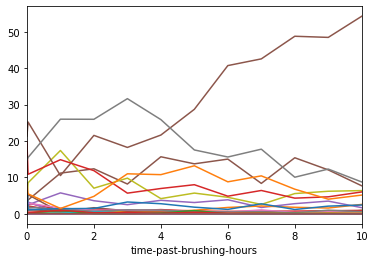

In [61]:
# lets create a quick plot to visualise how taxa are changing over time
# the legend is hidden, as it would just cover the whole plot
df.plot(x = 'time-past-brushing-hours', y = taxa_columns, legend=False)

In [76]:
# It appears that some taxa change quite significantly
# Let's figure out which ones change the most with a few quick operations
# Here we calulate the difference between maximum and mimium for each column and sort them
abund_changes = (df_norm[taxa_columns].max(axis=0)-df_norm[taxa_columns].min(axis=0))
abund_changes.sort_values(ascending=False).head(10)

k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Streptococcus                     43.721974
k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Neisseriales;f__Neisseriaceae;g__Neisseria                22.859984
k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;__;__                                     15.467826
k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Corynebacteriaceae;g__Corynebacterium    14.783196
k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Micrococcaceae;__                          12.515593
k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pasteurellales;f__Pasteurellaceae;g__Haemophilus         11.717737
k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pasteurellales;f__Pasteurellaceae;g__Aggregatibacter      7.299100
k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella                      5.167994
k__Bacteria;p__A

In [77]:
# it appears that Streptococcus and Neisseria experience quite some swing throughout the day
# let's see whether their correlation coefficients are also reasonably large
# with the .corrwith function we can correlate several data series (columns) with another
corr_coeff = df_norm[columns].corrwith(df['time-past-brushing-hours'])
# putting both series into one dataframe for easier intepretation
df2 = pd.concat([abund_changes, corr_coeff],axis=1)
df2.sort_values(by=0,ascending=False).head(10)

,0,1
k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Streptococcus,43.721974,0.908240
k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Neisseriales;f__Neisseriaceae;g__Neisseria,22.859984,-0.563428
k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;__;__,15.467826,-0.787514
k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Corynebacteriaceae;g__Corynebacterium,14.783196,-0.400740
k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Micrococcaceae;__,12.515593,0.416788
k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pasteurellales;f__Pasteurellaceae;g__Haemophilus,11.717737,0.057451
k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pasteurellales;f__Pasteurellaceae;g__Aggregatibacter,7.299100,-0.314396
k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella,5.167994,-0.482673
k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces,4.044568,-0.261294
k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Alloprevotella,3.205333,-0.636176


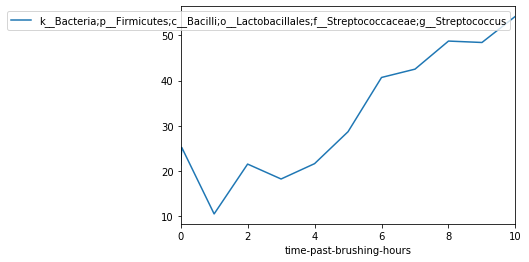

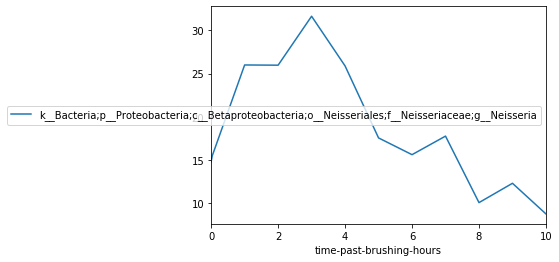

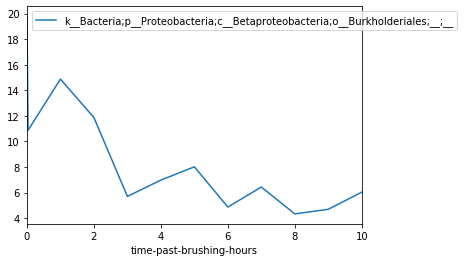

In [82]:
# This looks promising, let's plot some of the data to visualise
df.plot(x='time-past-brushing-hours', y = 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Streptococcus', kind='line')
df.plot(x='time-past-brushing-hours', y = 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Neisseriales;f__Neisseriaceae;g__Neisseria', kind='line')
df.plot(x='time-past-brushing-hours', y = 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;__;__', kind='line')

Simple correlation analysis can be done directly on the dataframe

In [83]:
# For more a thorough correlation analysis we need to import the stats package from scientific python (scipy)
from scipy import stats

In [87]:
# we can now carry out individual correlation tests on each of the top 3 taxa
# this will also provide a p-value
R, p = stats.pearsonr(df['k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Streptococcus'],df_norm['time-past-brushing-hours'])
print(f'The correlation coefficient is: {R}')
print(f'The p-value is: {p}')
stats.spearmanr(df['k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Streptococcus'],df_norm['time-past-brushing-hours'])

The correlation coefficient is: 0.9081599457066091
The p-value is: 4.402996475079413e-05


SpearmanrResult(correlation=0.8741258741258742, pvalue=0.00020071307332423193)

In [86]:
R, p = stats.pearsonr(df['k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Neisseriales;f__Neisseriaceae;g__Neisseria'],df_norm['time-past-brushing-hours'])
print(f'The correlation coefficient is: {R}')
print(f'The p-value is: {p}')
# or a non-parametric correlation test
stats.spearmanr(df['k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Neisseriales;f__Neisseriaceae;g__Neisseria'],df_norm['time-past-brushing-hours'])

The correlation coefficient is: -0.5637433336654067
The p-value is: 0.056263311098104576


SpearmanrResult(correlation=-0.5034965034965035, pvalue=0.09515736659412469)

In [88]:
R, p = stats.pearsonr(df['k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;__;__'],df_norm['time-past-brushing-hours'])
print(f'The correlation coefficient is: {R}')
print(f'The p-value is: {p}')
# or a non-parametric correlation test
stats.spearmanr(df['k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;__;__'],df_norm['time-past-brushing-hours'])

The correlation coefficient is: -0.7876550283022229
The p-value is: 0.0023509366896002507


SpearmanrResult(correlation=-0.8111888111888113, pvalue=0.0013633152527271922)

It appears that there is a strong and significant correlation between *Streptococcus* relative abundance and time after brushing teeth. 

The correlation in *Neisseira* abundance proofed non-significant (p > 0.05) and less strong. Though starting the correlation at a slightly later timepoint would probably provide different results.

Lastly, an unspecified genus from the order *Burkholderiales* also exhibits a strong, signficant correlation

The next step would now be to find biological reasons for these correlations.

## Further correlation analysis of taxonomic data with Python

The significant decrease in alpha diversity throughout the day suggests that taxa change significantly throughout the day. Usually a drop in diversity is associated with some taxa increasing relative abundance, ie. outcompeting others.

What better way to test this than with a few quick correlation tests in Python through the [Pandas](https://pandas.pydata.org/) packages.

In [1]:
# import pandas and execute jupyter magic to display plots inline
import pandas as pd
%matplotlib inline

First we need to extricate the data from the feature table. For this we collapse it to level 6 (genus), calculate relative frequency (feature table are absolute counts), export it and convert it from `.biom` format to a tab-separated value file.

In [81]:
%%time
# collapse to genus level
!qiime taxa collapse \
    --i-table deblur/table.qza \
    --i-taxonomy taxonomy/classification.qza \
    --p-level 6 \
    --o-collapsed-table taxonomy/genera-table.qza 

Saved FeatureTable[Frequency] to: taxonomy/genera-table.qza
CPU times: user 0 ns, sys: 46.9 ms, total: 46.9 ms
Wall time: 4.13 s


In [60]:
%%time
# create a table with relative rather than absolute frequence
!qiime feature-table relative-frequency \
    --i-table taxonomy/genera-table.qza \
    --o-relative-frequency-table taxonomy/rel-genera-table.qza

Saved FeatureTable[RelativeFrequency] to: taxonomy/rel-genera-table.qza
CPU times: user 0 ns, sys: 15.6 ms, total: 15.6 ms
Wall time: 4.05 s


In [65]:
%%time
# export feature table
!qiime tools export\
    --input-path taxonomy/rel-genera-table.qza \
    --output-path taxonomy/rel_genera

Exported taxonomy/rel-genera-table.qza as BIOMV210DirFmt to directory taxonomy/rel_genera
CPU times: user 0 ns, sys: 15.6 ms, total: 15.6 ms
Wall time: 3.86 s


In [71]:
%%time
# convert feature table from compressed .biom format to a text-based format
!biom convert \
    -i taxonomy/rel_genera/feature-table.biom \
    -o taxonomy/rel_genera/rel-genera-table.tsv \
    --to-tsv

CPU times: user 0 ns, sys: 15.6 ms, total: 15.6 ms
Wall time: 1.06 s


In [2]:
# load the relative abundance genera data as a pandas dataframe
# skipping the first row as this contains a comment
# assigning first column as row indices (names of genera)
df = pd.read_csv('taxonomy/rel_genera/rel-genera-table.tsv', sep='\t', skiprows=1, index_col=0)

In [3]:
df

,s11,s06,s05,s09,s07,s12,s08,s03,s04,s01,s02,s10
#OTU ID,,,,,,,,,,,,
Unassigned;__;__;__;__;__,0.000439,0.000207,0.001007,0.000000,0.000000,0.000000,0.000072,0.000648,0.003363,0.000000,0.000572,0.000000
k__Bacteria;p__Absconditabacteria_(SR1);c__Absconditabacteria_(SR1)_[C-1];o__Absconditabacteria_(SR1)_[O-1];f__Absconditabacteria_(SR1)_[F-1];g__Absconditabacteria_(SR1)_[G-1],0.000000,0.000331,0.000252,0.000329,0.000150,0.000000,0.000000,0.000540,0.000000,0.001607,0.003194,0.000061
k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;__;__,0.001135,0.000909,0.010908,0.000894,0.006382,0.009680,0.000399,0.001296,0.000163,0.001071,0.002145,0.000887
k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;__,0.000000,0.000372,0.000210,0.000094,0.000100,0.000000,0.000109,0.000162,0.000597,0.000000,0.000238,0.000061
k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces,0.035153,0.037268,0.025341,0.017650,0.031262,0.017168,0.038774,0.057613,0.036181,0.019952,0.025073,0.028138
k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Micrococcaceae;__,0.120766,0.156757,0.082022,0.083729,0.137415,0.077103,0.150312,0.111771,0.123786,0.031601,0.038181,0.154056
k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;__,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000399,0.000000,0.000000,0.000000,0.006244,0.000000
k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium,0.000000,0.000207,0.000000,0.000000,0.000150,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000061
k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Corynebacteriaceae;g__Corynebacterium,0.062177,0.041978,0.098175,0.025980,0.057140,0.063982,0.045586,0.173812,0.070627,0.039279,0.085371,0.055848


In [4]:
# .info() provides general information about the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 57 entries, Unassigned;__;__;__;__;__ to k__Bacteria;p__Spirochaetes;c__Spirochaetia;o__Spirochaetales;f__Spirochaetaceae;g__Treponema
Data columns (total 12 columns):
s11    57 non-null float64
s06    57 non-null float64
s05    57 non-null float64
s09    57 non-null float64
s07    57 non-null float64
s12    57 non-null float64
s08    57 non-null float64
s03    57 non-null float64
s04    57 non-null float64
s01    57 non-null float64
s02    57 non-null float64
s10    57 non-null float64
dtypes: float64(12)
memory usage: 5.8+ KB


In [5]:
# calculating which features experience the biggest 
# axis=1 mean calculating along rows
(df.max(axis=1)-df.min(axis=1)).sort_values(ascending=False)

#OTU ID
k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Streptococcus                                                                                       0.437220
k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Neisseriales;f__Neisseriaceae;g__Neisseria                                                                                  0.228600
k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;__;__                                                                                                       0.154678
k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Corynebacteriaceae;g__Corynebacterium                                                                      0.147832
k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Micrococcaceae;__                                                                                            0.125156
k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria

In [6]:
# let's also load the metadata, so we can correlate relative abundances with time
df2 = pd.read_csv('oral_microbiome.tsv', sep='\t', skiprows=3, header=None)
df2.columns = ['id','barcode-sequence','time','time-past-brushing-hours','liquid-consumed','liquid-type','volume-ml','food-consumed','food','refined-sugars-g','teeth-brushing']
df2

,id,barcode-sequence,time,time-past-brushing-hours,liquid-consumed,liquid-type,volume-ml,food-consumed,food,refined-sugars-g,teeth-brushing
0,s01,GTGAATGTTCGA,08:00,0.000000,Y,Water,250,N,N,0,N
1,s02,TATGTTGACGGC,08:02,0.033333,N,NaN,0,N,N,0,Y
2,s03,AGTGTTTCGGAC,09:00,1.000000,N,NaN,0,N,N,0,N
3,s04,ATTTCCGCTAAT,10:00,2.000000,Y,Water,250,Y,"5 pancakes, 1 banana, 1tbsp syrup",24,N
4,s05,CAAACCTATGGC,11:00,3.000000,Y,Tea,250,N,N,0,N
5,s06,CATTTGACGACG,12:00,4.000000,N,NaN,0,N,N,0,N
6,s07,ACTAAGTACCCG,13:00,5.000000,Y,Jasmine Tea,250,N,N,0,N
7,s08,CACCCTTGCGAC,14:00,6.000000,Y,Water,250,Y,"Sweet potato mash, roasted tomato, broccoli, c...",0,N
8,s09,GATGCCTAATGA,15:00,7.000000,N,NaN,0,N,N,0,N
9,s10,GTACGTCACTGA,16:00,8.000000,N,NaN,0,N,N,0,N


In [7]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 11 columns):
id                          12 non-null object
barcode-sequence            12 non-null object
time                        12 non-null object
time-past-brushing-hours    12 non-null float64
liquid-consumed             12 non-null object
liquid-type                 6 non-null object
volume-ml                   12 non-null int64
food-consumed               12 non-null object
food                        12 non-null object
refined-sugars-g            12 non-null int64
teeth-brushing              12 non-null object
dtypes: float64(1), int64(2), object(8)
memory usage: 1.1+ KB


In [8]:
time = df2['time-past-brushing-hours']
time

0      0.000000
1      0.033333
2      1.000000
3      2.000000
4      3.000000
5      4.000000
6      5.000000
7      6.000000
8      7.000000
9      8.000000
10     9.000000
11    10.000000
Name: time-past-brushing-hours, dtype: float64

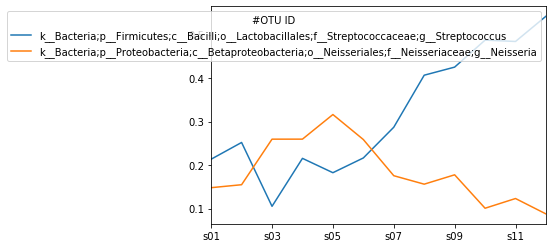

In [9]:
# for a quick correlation analysis, we can use the corrwith function
strep_neiss = df.loc[['k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Streptococcus','k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Neisseriales;f__Neisseriaceae;g__Neisseria'],:].transpose()
strep_neiss.sort_index(inplace=True)
strep_neiss.plot()

In [10]:
strep_neiss['time'] = time
strep_neiss

#OTU ID,k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Streptococcus,k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Neisseriales;f__Neisseriaceae;g__Neisseria,time
s01,0.213489,0.147965,NaN
s02,0.251966,0.154774,NaN
s03,0.105076,0.259557,NaN
s04,0.215405,0.259615,NaN
s05,0.182421,0.316216,NaN
s06,0.216337,0.258728,NaN
s07,0.286996,0.175509,NaN
s08,0.406689,0.156037,NaN
s09,0.425284,0.177578,NaN
s10,0.487399,0.100685,NaN


In [11]:
strep_neiss['k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Streptococcus']

s01    0.213489
s02    0.251966
s03    0.105076
s04    0.215405
s05    0.182421
s06    0.216337
s07    0.286996
s08    0.406689
s09    0.425284
s10    0.487399
s11    0.484273
s12    0.542295
Name: k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Streptococcus, dtype: float64

In [12]:
df.transpose()['Unassigned;__;__;__;__;__'].corr(df2[['time-past-brushing-hours']])

nan